In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
import umap
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

from tqdm import tqdm
import os

from src.models import SpaceNet, RecurrentSpaceNet, Decoder
from src.utils import ratemap_collage, SimpleDatasetMaker, get_ratemaps

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

In [2]:
def characterize_transformation(T):
    """
    Characterizes a transformation matrix T.
    """
    
    # Compute SVD to get singular values
    U, singular_values, Vt = np.linalg.svd(T)
    
    # Condition number
    cond_number = singular_values.max() / singular_values.min()
    
    # Frobenius norm
    fro_norm = np.linalg.norm(T, 'fro')
    
    # Eigenvalues (if T is square)
    if T.shape[0] == T.shape[1]:
        eigenvalues, _ = np.linalg.eig(T)
    else:
        eigenvalues = None
    
    det = np.linalg.det(T)
    
    return {
        "Singular Values": singular_values,
        "Condition Number": cond_number,
        "Frobenius Norm": fro_norm,
        "Eigenvalues": eigenvalues,
        "Determinant": det
    }

def get_orthogonal_transformation(A, B):
    """
    Finds an orthogonal transformation matrix T that maps A to B.
    
    Parameters
    ----------
    A : np.ndarray
        Matrix of shape (n_units, positions)
    B : np.ndarray
        Matrix of shape (n_units, positions)
    
    Returns
    -------
    T : np.ndarray
        Orthogonal transformation matrix of shape (n_units, n_units)
    """
    # Center the data
    A_centered = A - np.mean(A, axis=1, keepdims=True)
    B_centered = B - np.mean(B, axis=1, keepdims=True)
    
    # A_centered = A
    # B_centered = B
        
    # Compute the cross-covariance matrix
    C = A_centered @ B_centered.T

    # Compute the SVD of the cross-covariance matrix
    U, S, Vt = np.linalg.svd(C)

    # Calculate the transformation matrix
    T = Vt.T @ U.T

    return T


In [28]:
figure_path = os.path.join(os.getcwd(), "figures")
model_path = os.path.join(os.getcwd(), "models")
results_path = os.path.join(os.getcwd(), "results")

In [35]:
# Maps a model label to the corresponding model name as it is saved
model_name_map = {
    "256": r"$n=256$",
    "256_0beta": r"$n=256 \: \beta=0$",
    "256_025beta": r"$n=256 \: \beta=0.25$",
    "256_075beta": r"$n=256 \: \beta=0.75$",

    # Scale grid
    "256_01scale": r"$n=256 \: \sigma=0.1$",
    "256_05scale": r"$n=256 \: \sigma=0.5$",

    # n grid
    "512": r"$n=512$",
    "1024": r"$n=1024$",

    "256_context": r"$n=256 \: context$",

    "256_ff_context": r"$n=256 \: ff \: context$",
    "256_ff": r"$n=256 \: ff$",
}

# Load models and loss histories
models, loss_histories = {}, {}
for name, label in model_name_map.items():
    models[name] = [torch.load(os.path.join(model_path, f"{name}_{i}.pt")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}.pt"))]
    loss_histories[name] = [np.load(os.path.join(model_path, f"{name}_{i}_loss_history.npy")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}_loss_history.npy"))]

    # Remove if empty
    if len(models[name]) == 0:
        del models[name]
        del loss_histories[name]

## Example trajectories

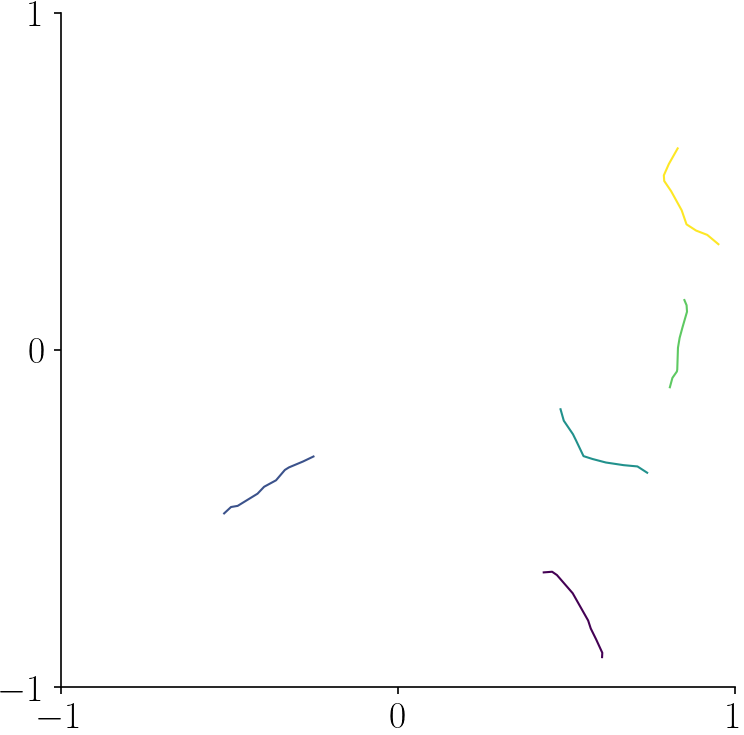

In [30]:
cmap = plt.get_cmap("viridis")
genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(5, 10)
colors = [cmap(i) for i in np.linspace(0, 1, r.shape[0])]

fig, ax = plt.subplots(figsize=(5, 5))
for k, traj in enumerate(r):
    ax.plot(*traj.detach().numpy().T, color=colors[k], lw=1)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.set_xticks(np.linspace(-1, 1, 3))
ax.set_yticks(np.linspace(-1, 1, 3))
ax.set_aspect('equal')
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_example_trajectories.svg'), transparent=True)

## Loss

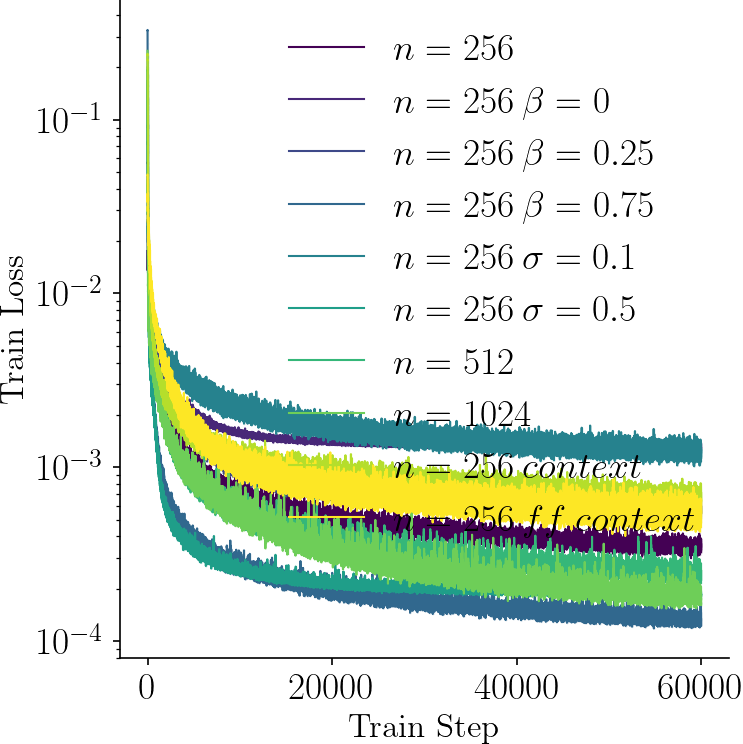

In [6]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()
# fig.savefig(os.path.join(figure_path, 'rnn_training_loss.svg'), transparent=True)
plt.show()


## Ratemaps

In [32]:
models.keys()

dict_keys(['256', '256_0beta', '256_025beta', '256_075beta', '256_01scale', '256_05scale', '512'])

In [77]:
model_name = "256"

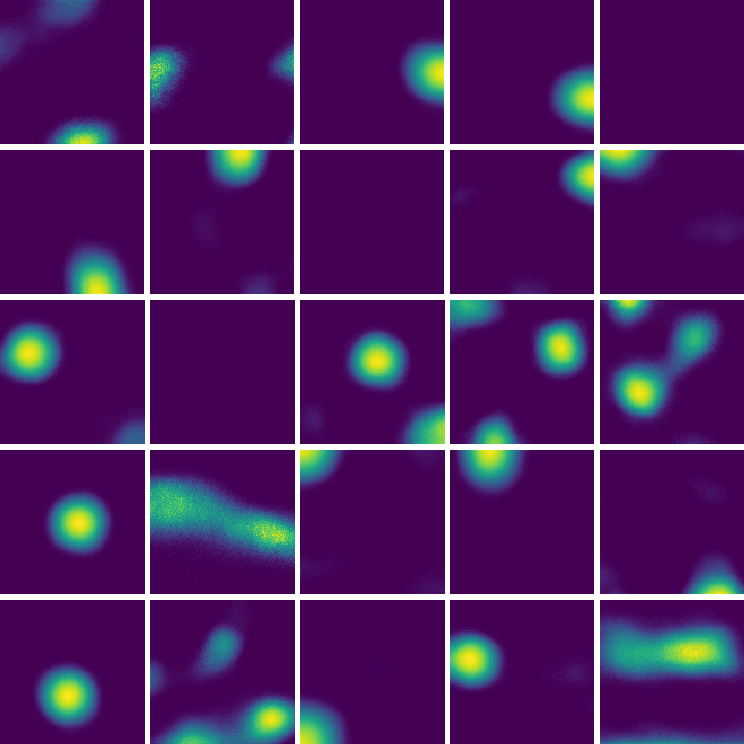

In [78]:
model = models[model_name][0]
ratemaps = get_ratemaps(model, bins=128, timesteps=10, n_traj=100000, context=None, context_in_initial=True)

# Plot first 25 ratemaps (active units)
plt_ratemaps = ratemaps[np.max(ratemaps, axis=(1, 2)) > 0.01]
plt_ratemaps = ratemaps
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")     
plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_ratemaps_{model_name}_high_peak.svg'), transparent=True)

Peak and mean rate distribution

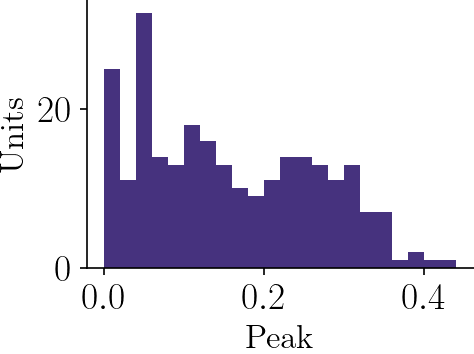

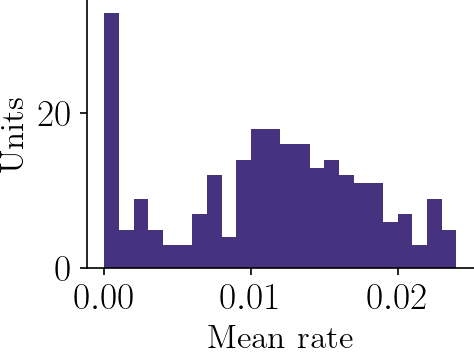

In [79]:
fig, ax = plt.subplots()
ax.hist(np.max(ratemaps, axis=(1, 2)), bins=np.arange(0, 0.45, 0.02))
ax.set_ylabel("Units")
ax.set_xlabel("Peak")
plt.show()

fig, ax = plt.subplots()
ax.hist(np.mean(ratemaps, axis=(1, 2)), bins=np.arange(0, 0.025, 0.001))
ax.set_ylabel("Units")
ax.set_xlabel("Mean rate")
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_peaks.svg'), trans
# parent=True)

Threshold on mean rate

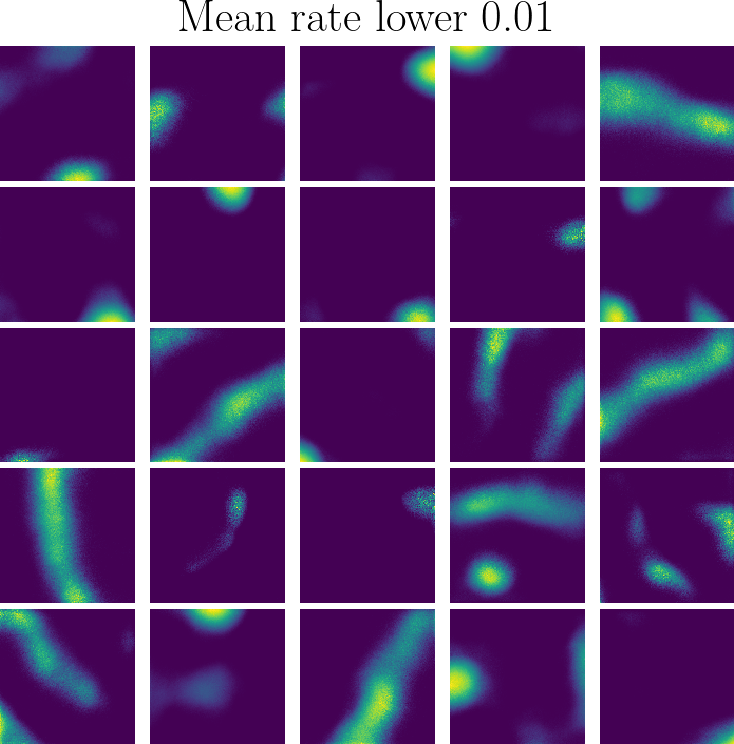

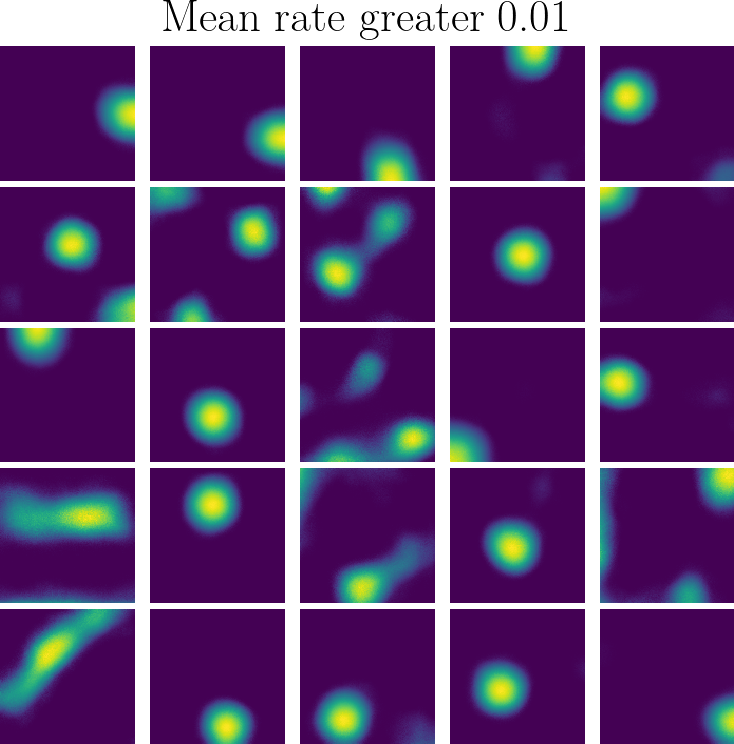

In [82]:
thresh = 0.01

plt_ratemaps = ratemaps[(np.mean(ratemaps, axis=(1, 2)) < thresh) & (np.mean(ratemaps, axis=(1, 2)) > 1e-5)]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")
fig.suptitle(f"Mean rate lower {thresh}")
plt.show()

plt_ratemaps = ratemaps[(np.mean(ratemaps, axis=(1, 2)) >= thresh)]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")
fig.suptitle(f"Mean rate greater {thresh}")
plt.show()

## Peak positions of units

In [83]:
model_name = "256"
model = models[model_name][0]

In [84]:
bins = 128

# Get ratemaps
ratemaps = get_ratemaps(model, bins=bins)

# Find peak positions
peak_idx = np.argmax(ratemaps.reshape(-1, bins*bins), axis=-1)
x = np.linspace(-1, 1, bins)
y = x.copy()
xx, yy = np.meshgrid(x,y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
peak_loc = grid[peak_idx]

# Find units with nonzero values
mask = np.mean(ratemaps, axis=(1, 2)) > 0.01

print(f"Resolution: {2/bins:.3f}")
print(f"Percentage of units meeting criterion: {np.mean(mask) * 100:.2f}%")

Resolution: 0.016
Percentage of units with nonzero values: 62.89%


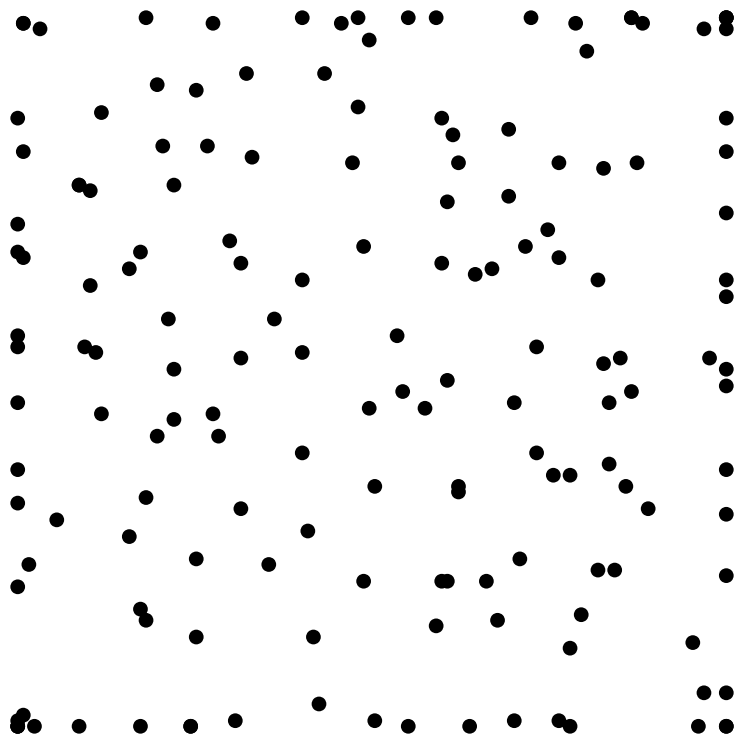

In [85]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(peak_loc[mask, 0], peak_loc[mask, 1], marker="o", color="black", s=50, alpha=1, edgecolors='none')
ax.axis("off")
ax.set_ylim(-1.05, 1.05)
ax.set_xlim(-1.05, 1.05)
ax.invert_yaxis()
plt.show()
# fig.savefig(os.path.join(figure_path, f'dense_peak_positions_{model_name}.svg'), transparent=True)

## Scale

In [73]:
def gaussian_2d(x_mesh, y_mesh, A, x0, y0, sigma_x, sigma_y, theta, offset):
    a = (np.cos(theta) ** 2) / (2 * sigma_x ** 2) + (np.sin(theta) ** 2) / (2 * sigma_y ** 2)
    b = (-np.sin(2 * theta)) / (4 * sigma_x ** 2) + (np.sin(2 * theta)) / (4 * sigma_y ** 2)
    c = (np.sin(theta) ** 2) / (2 * sigma_x ** 2) + (np.cos(theta) ** 2) / (2 * sigma_y ** 2)
    return offset + A * np.exp(- (a * (x_mesh - x0) ** 2
                                  + 2 * b * (x_mesh - x0) * (y_mesh - y0)
                                  + c * (y_mesh - y0) ** 2))
def fit_gaussian_2d(ratemap):
    """
    Fits a 2D Gaussian to the given ratemap and returns the estimated parameters and MSE.

    Parameters:
    ----------
    ratemap : numpy.ndarray
        2D array representing the data to fit.

    Returns:
    -------
    params : dict
        Dictionary containing the estimated parameters:
            - amplitude
            - offset
            - x0 (centroid x-coordinate)
            - y0 (centroid y-coordinate)
            - sigma_x (standard deviation along x)
            - sigma_y (standard deviation along y)
            - theta (orientation angle in radians)
            - mse (mean squared error)
    """
    # Ensure the input is a numpy array
    ratemap = np.asarray(ratemap)
    
    # Get the dimensions of the array
    height, width = ratemap.shape

    # Create coordinate arrays corresponding to each element in 'ratemap'
    x = np.arange(width)
    y = np.arange(height)
    x_mesh, y_mesh = np.meshgrid(x, y)

    # Compute the total intensity (sum of all data values)
    total_intensity = np.sum(ratemap)

    # Compute the weighted mean (centroid) coordinates (x0, y0)
    x0 = np.sum(x_mesh * ratemap) / total_intensity
    y0 = np.sum(y_mesh * ratemap) / total_intensity

    # Compute the differences from the mean
    x_diff = x_mesh - x0
    y_diff = y_mesh - y0

    # Compute the covariance matrix elements
    sigma_xx = np.sum(ratemap * x_diff ** 2) / total_intensity
    sigma_yy = np.sum(ratemap * y_diff ** 2) / total_intensity
    sigma_xy = np.sum(ratemap * x_diff * y_diff) / total_intensity

    # Construct the covariance matrix
    cov_matrix = np.array([[sigma_xx, sigma_xy],
                           [sigma_xy, sigma_yy]])

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # The eigenvalues correspond to the variances along the principal axes
    # Eigenvalues are sorted in ascending order
    sigma1_squared = eigvals[0]
    sigma2_squared = eigvals[1]

    # Standard deviations along the principal axes
    sigma_x = np.sqrt(sigma2_squared)  # Along the major axis
    sigma_y = np.sqrt(sigma1_squared)  # Along the minor axis

    # Orientation angle theta (in radians)
    # The eigenvector corresponding to the largest eigenvalue gives the orientation
    principal_axis = eigvecs[:, 1]
    theta = np.arctan2(principal_axis[1], principal_axis[0])

    # Estimate amplitude and offset
    offset = np.min(ratemap)
    amplitude = np.max(ratemap) - offset

    # Generate the fitted Gaussian data
    data_fitted = gaussian_2d(x_mesh, y_mesh, amplitude, x0, y0, sigma_x, sigma_y, theta, offset)

    # Compute residuals and mean squared error
    residuals = ratemap - data_fitted
    mse = np.mean(residuals ** 2)

    # Prepare the parameters dictionary
    params = {
        'amplitude': amplitude,
        'offset': offset,
        'x0': x0,
        'y0': y0,
        'sigma_x': sigma_x,
        'sigma_y': sigma_y,
        'theta': theta,  # in radians
        'mse': mse
    }

    return params

In [74]:
gaussian_fits = pd.DataFrame([fit_gaussian_2d(ratemap) for ratemap in ratemaps])

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_37786/2453164148.py:45: RuntimeWarning: invalid value encountered in double_scalars
  x0 = np.sum(x_mesh * ratemap) / total_intensity
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_37786/2453164148.py:46: RuntimeWarning: invalid value encountered in double_scalars
  y0 = np.sum(y_mesh * ratemap) / total_intensity
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_37786/2453164148.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  a = (np.cos(theta) ** 2) / (2 * sigma_x ** 2) + (np.sin(theta) ** 2) / (2 * sigma_y ** 2)
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_37786/2453164148.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  b = (-np.sin(2 * theta)) / (4 * sigma_x ** 2) + (np.sin(2 * theta)) / (4 * sigma_y ** 2)
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_37786/2453164148.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  

/Users/frederikrogge/miniforge3/envs/bsr/lib/python3.10/site-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)


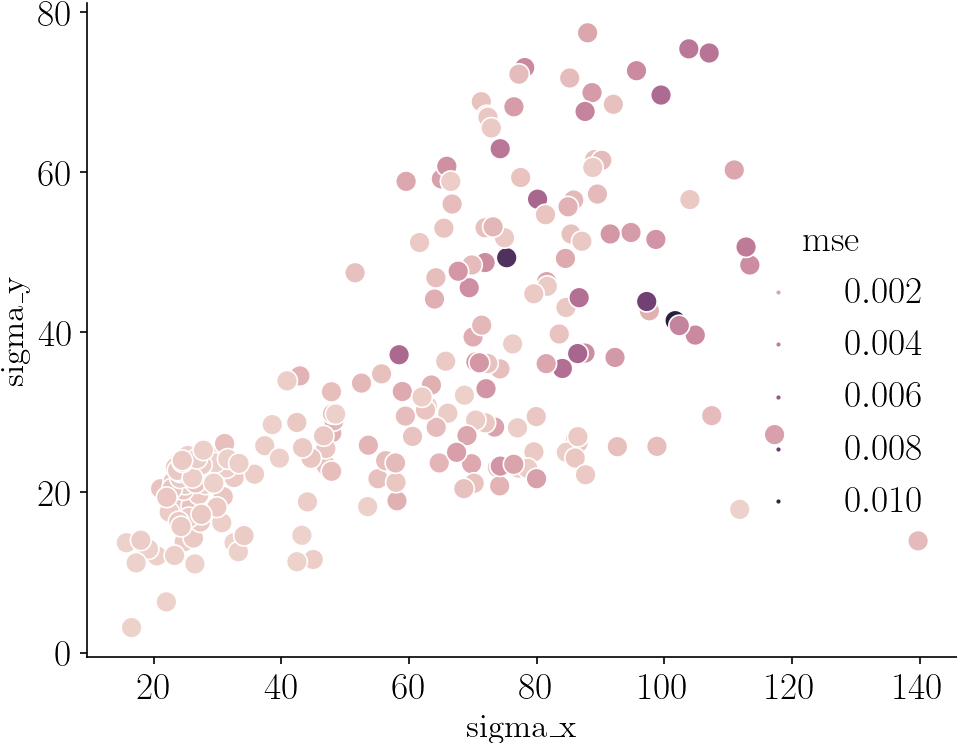

In [75]:
sns.relplot(
    data=gaussian_fits,
    x="sigma_x",
    y="sigma_y",
    hue="mse",
    kind="scatter",
    s=100,
    
)

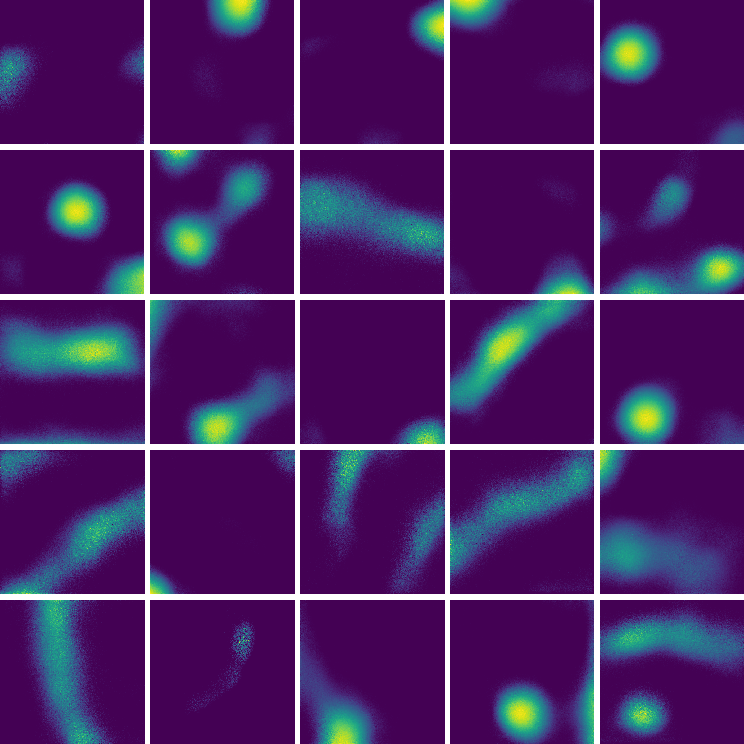

In [76]:
plt_ratemaps = ratemaps[(gaussian_fits["mse"] < 0.003) & (gaussian_fits["sigma_x"] > 40)]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")     
plt.show()

## Similarity structure / Error maps

In [55]:
model_name = "256 units"
model = models[model_name][0]

pos_name = "center"
scale = 0.25
beta = 0.5

positions = {
    'center': [128, 128],
    'corner': [0, 0],
    'bottom': [64, 128]
}

pos = positions[pos_name]

In [77]:
bins = 128
ratemaps = get_ratemaps(model, bins=bins, timesteps=10, n_traj=100000)

p = ratemaps.reshape(256, -1).T 

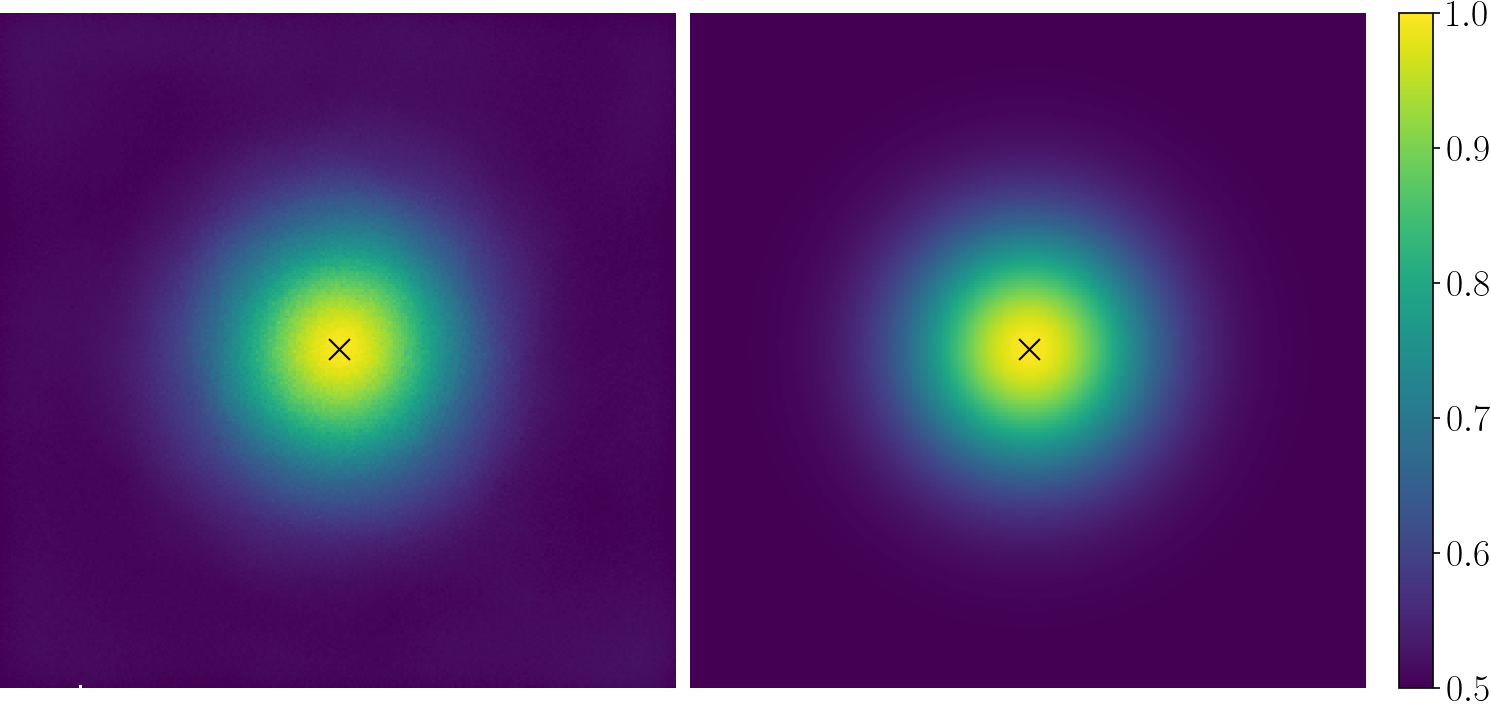

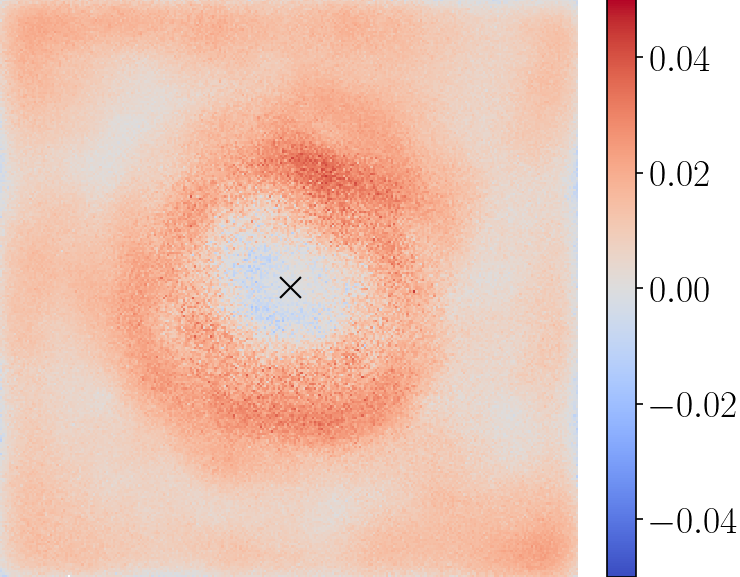

In [78]:
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (bins, bins))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)
grid_corr = (1 - beta) * grid_corr + beta

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Spatial representations
im = axs[0].imshow(corr.reshape(bins, bins), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(bins, bins), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(5, 5))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
im = axs.imshow((corr - grid_corr).reshape(bins, bins), origin="lower", cmap="coolwarm", vmin=-0.05, vmax=0.05)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

## Maps across different contexts

In [45]:
model_name = "256_ff_context"
model = models[model_name][0]

In [46]:
n_cells = 10
contexts = np.linspace(-2, 2, 10)
maps = []
for context in contexts:
    ratemaps = get_ratemaps(model, bins=64, timesteps=10, n_traj=100000, context=context, context_in_initial=True)
    maps.append(ratemaps)
maps = np.array(maps)


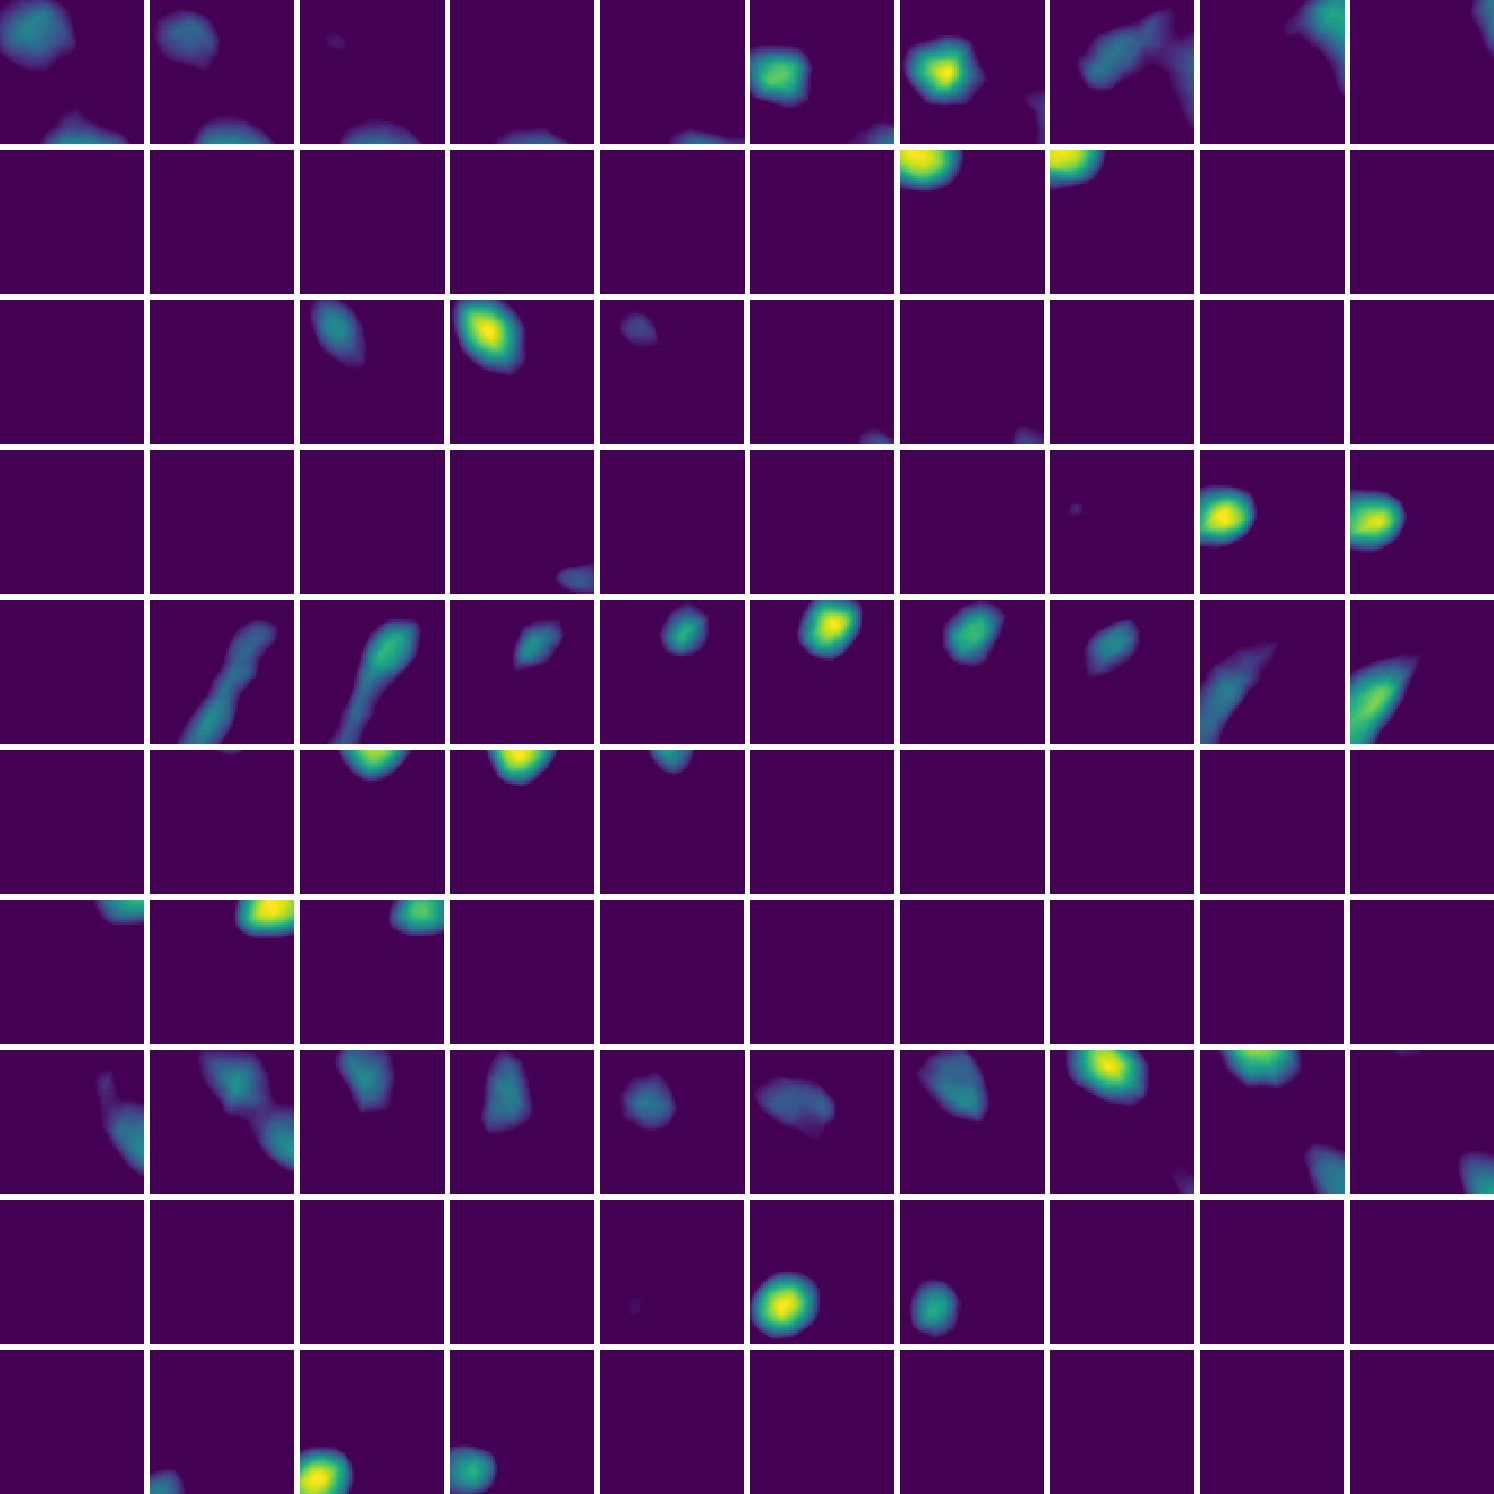

In [48]:
# Find cells that are active somewhere
active = np.max(maps, axis=(0, 2, 3)) > 0.1

fig, axs = plt.subplots(ncols=len(contexts), nrows=n_cells, figsize=(len(contexts), n_cells))
for i, n in enumerate(np.where(active)[0][:10]):
    max_val = np.max(maps[:, n])
    for j in range(len(contexts)):
        axs[i, j].imshow(maps[j, n], cmap="viridis", vmin=0, vmax=max_val)
        axs[i, j].axis("off")
plt.show()